# MCMC Fitting
In this lab we will look at implementing a simple Markov Chain Monte Carlo to fit data

In [1]:
#Bring in our imports
import numpy as np

from scipy.optimize import minimize #curve_fit

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 15}) # set default fontsize

from IPython.display import display, Math # print results for MCMC

# emcee Installation

First install the emcee and corner packages if you have not already done so with pip in the terminal using:

pip install emcee

pip install corner

In [2]:
import emcee
import corner

For more about the emcee package see both the documentation (https://emcee.readthedocs.io/en/stable/) and accompanying paper https://arxiv.org/pdf/1202.3665.pdf 

# What is an MCMC?

MCMC stands for Markov Chain Monte Carlo. This leads to two questions: What is a Markov Chain? What is Monte Carlo?

To anwser is the first question, a Markov chain is a random process that the future state only depends on the current and is not relient on the past. Think about a random walk where you have two options (left or right). Let's say there is a equal probability of each direction and since the next state does not depend on where the walker was 2 steps, or 3 steps or even 10,000 steps ago, this is a Markov chain. 

Monte Carlo methods/experiments are computational algorithms that use repeated random samplying to numerical calculate a deterministic process. Often times these are used to calculate integrals or parameter marginalization.

An MCMC is a Monte Carlo experiment that makes use of a Markov chain and is generally more efficient than a plain Monte Carlo. The idea is to create a Markov chain that will have the desired probability distribution after some number of steps. Here we will use it to fit some parameters.

First let's start with Bayes' Theorem, which states:

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

where $P(A|B)$ is the probability of A given B, $P(A|B)$ is probability of B given A, $P(A)$ is the prior distribution, and  $P(B)$ is the evidence.

Bayes' Theorem describes the probability of an event represented by the posterior distribution given prior knowledge about related events. Built upon this idea, Bayesian inference is a form of statistical inference that uses Bayes' Theorem to update the probability of an event based on observation.

The likelihood function ($P(B|A)$) is a joint probability distrubution of the observed data as a function of the parameters of the chosen data. You cannot draw samples from this distribution so that is why we need Bayes' Theorem to get something meaningful in MCMC. The likelihood is a distribution over different datasets.

The prior distribution is where the we stick our knowledge about what we already know or believe. 

The probability of evidence (P(B)) (colloquially the evidence) is a distriution describing how likely $B$ is without knowing prior information. Many times the evidence can be thought of as a normalization factor and can be ignored.

The Posterior distribution ($P(A|B)$) is the probability distribution that describes the event of interest.

$\textbf{It is important to note that the evidence cannot be dropped in every circumstance such as when doing model comparisons.}$

For our purposes we will drop the evidence so that 

$P(A|B) \propto P(B|A)P(A)$

Since the posterior is the product of two distributions sometimes that can be quite cumbersome to calculate so generally the logarithm of Bayes' Theorme is used. Doing this gives:

$\log{P(A|B)} \propto \log{P(B|A)} + \log{P(A)}$

Many times the logarithm is assumed to be the natural log so for our purposes it can be assumed that both $\log = \ln$. Many times in literature the log likelihood is denoted $\ln \mathcal{L}$.

# Time to do an MCMC

Let's start with a simple linear model (adpated from the emcee documentation)

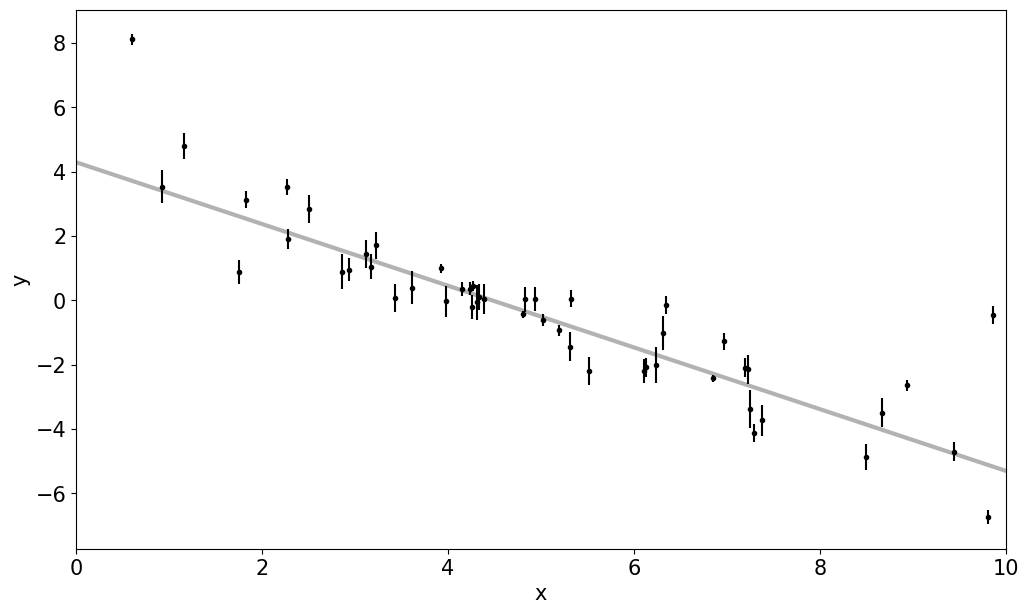

In [3]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534 # more on this later

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

# Plot the data and true model
plt.figure(figsize=[12,7])
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Doing a basic linear least squares fit gives

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


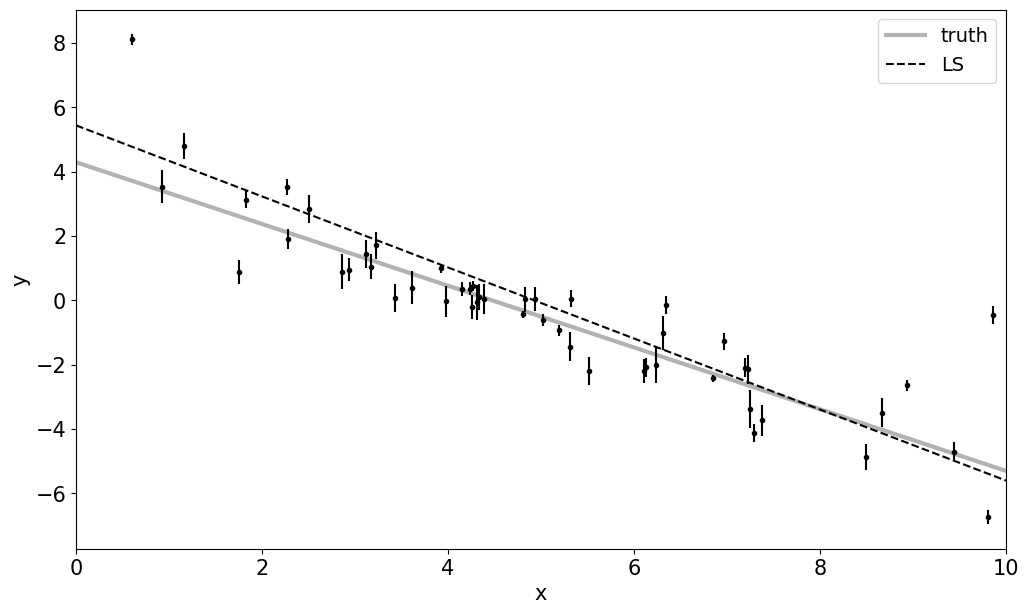

In [4]:
# Do linear least squares
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2)) # Invert to find the solution
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

# Plot results
plt.figure(figsize=[12,7])
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Now to the MCMC to fit the same party parameters. First let's construct the log likelihood and use maximum likliehood estimation (MLE). 

Keep in mind that the general Gaussian likelihood is:

$\mathcal{L}(y_n|x_n,\sigma_n,\vec{\theta}) = \prod_n \frac{1}{\sqrt{2\pi \sigma_n}} exp \bigg[-\frac{(y_n - \mu(x_n|\vec{\theta}))^2}{2\sigma_n^2} \bigg]$ 

where $\mu(x_n|\vec{\theta})$ is the model with parameters $\vec{\theta}$. With a Gaussian likelihood it is assumed that each individual measurement of $x_n$ follows a Gaussian with errors $\sigma_n$

The log likelihood for the specific linear model in this case is:

$\ln \mathcal{L}(y|x,\sigma,m,b,f) = -\frac{1}{2}\sum_n\bigg[\frac{(y_n - mx_n - b)^2}{s_n^2} + \ln(2\pi s_n^2)\bigg]$, $s_n^2 = \sigma^2_n + f^2 (mx_n+b)^2$

So why is $s_n^2$ not just $\sigma_n^2$ and what is $f$? In the creation of the synthetic data extra noise proportional to the signal was created. This means that the $\sigma_n$ are underestimates of the true noise by some fractional amount of the signal with strength determined based on $f$.

Coding this up gives:

In [5]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Note here that the log likelihood uses the log of $f$. This is because later when doing the MCMC it will be useful when coding up the log prior.

Now let's do the MLE for the parameter estimation.

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


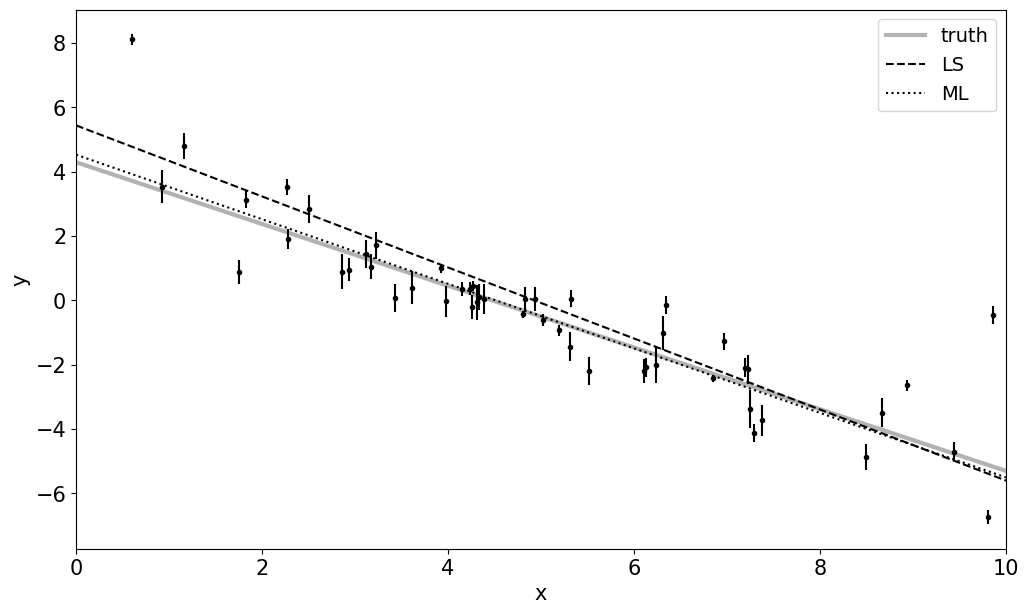

In [6]:
from scipy.optimize import minimize

# Do the MLE
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args) # negative log likelihood
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3) # initial guesses
soln = minimize(nll, initial, args=(x, y, yerr)) # minimize? I thought this was MLE
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

# Plot the results
plt.figure(figsize=[12,7])
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

As seen in the cell above we actually used the minimize function from scipy.optimize. Notice we plugged the negative log likelihood into minimize. Think about the parabola $-x^2$, which has a maximum at $x = 0$. If we look at the negative of this parabola we now has a minimum at $x = 0$, which is the same place as the maximum of $-x^2$.

Ok so what are the uncertainties in the MLE parameters? That's where MCMC comes.

Now let's make a log prior for this linear model. 

We will use uniform priors on all of the parameters. Sometimes a uniform prior is called "uninformative".

For the slope of the line, the y intercept, and log(f) lets use:

$p(m) =\begin{cases} 1/5.5 & -5 < x < 0.5 \\ 0 & else \end{cases}$

$p(b) =\begin{cases} 1/10 & 0.0 < x < 10.0 \\ 0 & else \end{cases}$

$p(log(f)) =\begin{cases} 1/11 & -10.0 < x < 1.0 \\ 0 & else \end{cases}$

Up to a cosntant the log prior in code is:

In [7]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

Constructing the RHS of Bayes' theorem above is then:

In [8]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

It is time to do the MCMC now.

In [9]:
# intial positions of walkers for all three parameters
pos = soln.x + 1e-4 * np.random.randn(50, 3) 
nwalkers, ndim = pos.shape

# sample the distribution an marginalize
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True); # run for 5000 steps

100%|██████████████████████████████████████| 5000/5000 [00:07<00:00, 708.68it/s]


The samples can be accessed using the EnsembleSampler.get_chain() method. This will return an array with the shape (5000, 32, 3) giving the parameter values for each walker at each step in the chain.

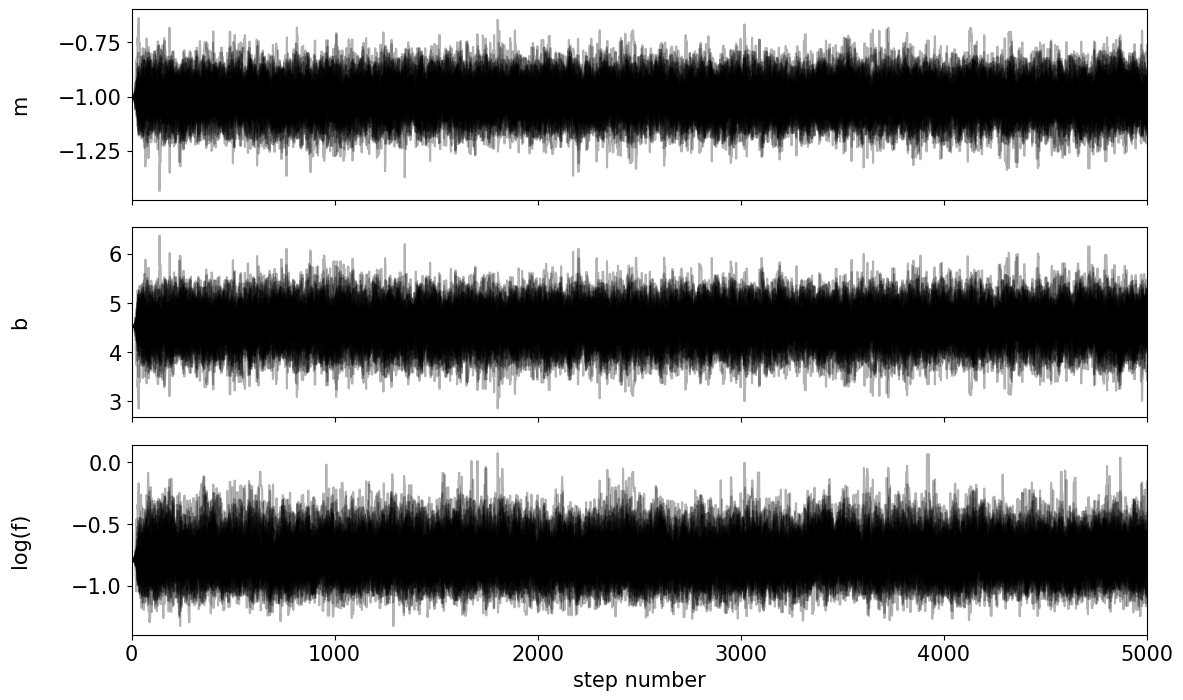

In [11]:
fig, axes = plt.subplots(3, figsize=(12, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

plt.tight_layout()
axes[-1].set_xlabel("step number");

If you look closely you will see the above distributions are not quite as wide intially. This is because the walkers have yet to "forget" where they started and have not begun to search the whole of parameter space. These first steps are known as "burn-in" and we want to cut them out so they are forgot when extracting the parameters an uncertainties.

An estimation of how many steps it took to burn-in can be found by looking at the auto-correlation time. To do this in practice:

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

[36.2772455  36.58944076 35.93880825]


So it took just under 40 steps.

We will extract the the distributions for each of the parameters by getting rid of at least 40 steps plus a few more (let's say the first 100 steps) and flattening the distributions. We also thin out the distributions by taking only every 15 steps (just about half of the auto correlation time).

In [13]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 3)


A corner plot is a useful way to visualize the results of the MCMC and look at the distributions for each of the parameters and their associated joint distributions.

<Figure size 1200x1200 with 0 Axes>

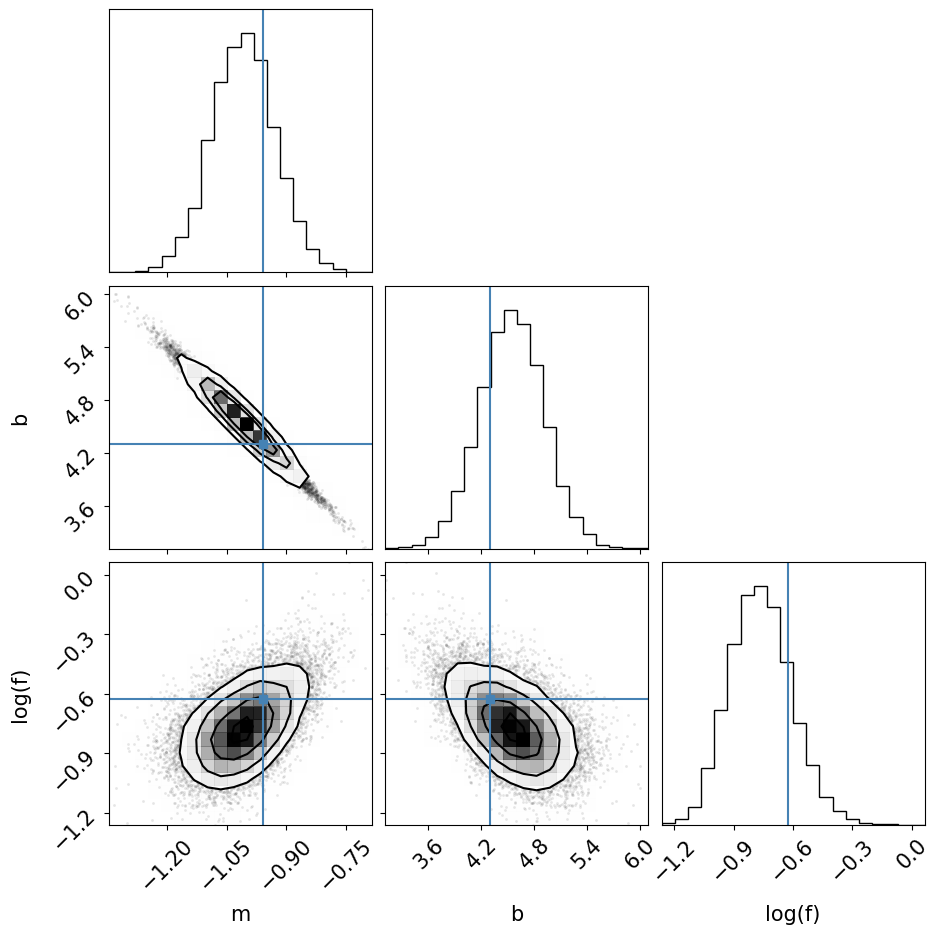

In [14]:
plt.figure(figsize=[12,12])
corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)],
              smooth=0.5,fig=plt.figure(figsize=[10,10]));

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

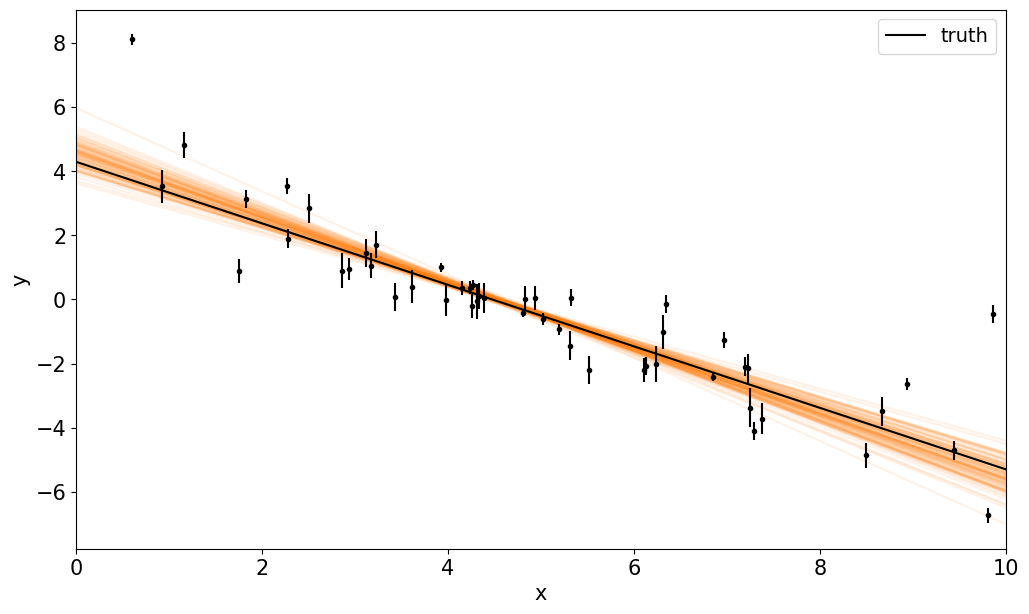

In [15]:
from IPython.display import display, Math

# print the fitted parameters
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
inds = np.random.randint(len(flat_samples), size=100)

# Plot the MCMC results
plt.figure(figsize=[12,7])
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

# Now It's Your Turn

Stellar spectra are bulit upon that of a blackbody, though stars are not perfect blackbodies. The blackbody intensity is given by Planck's law which is:

$\large{\frac{2hc^2}{\lambda^5} \frac{1}{{exp[\frac{hc}{\lambda k_B T}]-1}}}$

where $h$ is Planck's constant, $c$ is the speed of light, $k_B$ is the Boltzmann constant, $\lambda$ is the wavelength and $T$ is the temperature.

The spectrum of a star very far away will be affected by redshift (z) with higher redshift corresponding to a further distance. Under redshift the temperature of a star will be transformed as:

$T \rightarrow \frac{T_0}{1+z}$

and the wavelength of a star will be transformed as:

$\lambda \rightarrow \lambda_0(1+z)$

where $T_0$ and $\lambda_0$ are the actual temperature and wavelengths (not the measured ones) respectively. Plugging these into the blackbody instensity equation gives:

$\large{\frac{2hc^2}{\lambda_0^5 (1+z)^5} \frac{1}{{exp[\frac{hc}{\lambda_0 k_B T_0}]-1}}}$

Coding this up looks like:

In [19]:
from astropy.constants import h, k_B, c
from astropy import units as u

def blackbody(wavelength,temperature,z):
    '''
    Blackbody intensity as a function of wavelength, temperature and redshift
    
    Inputs:
    ------
        wavelength:  array-like
                     wavelength(s) in units of Angstroms to calculate the intensities for
                        
        temperature: float
                     the actual temperature in units of Kelvin
        
        z:           float
                     the redshift z
                     
    Return:
    ------
        intensity:   array-like
                     blackbody intensity in cgs units but with angstroms for wavelength erg s^-1 cm^-2 AA^-1
    '''
    
    wave_cgs = (wavelength*u.AA).to(u.cm)
    temp_cgs = temperature*u.K
    h_cgs = h.to(u.erg*u.s) 
    c_cgs = c.to(u.cm/u.s)
    k_cgs = k_B.to(u.erg/u.K)
    
    intensity = 2*h_cgs*c_cgs**2 / (wave_cgs**5 * (1+z)**5 * (np.exp(h_cgs*c_cgs/(wave_cgs*k_cgs*temp_cgs)) - 1))
    intensity = (intensity.to(u.erg/(u.s*u.cm**2*u.AA))*4*np.pi).value # get rid of steradians and units

    return intensity

Time to generate some data for the blackbody:

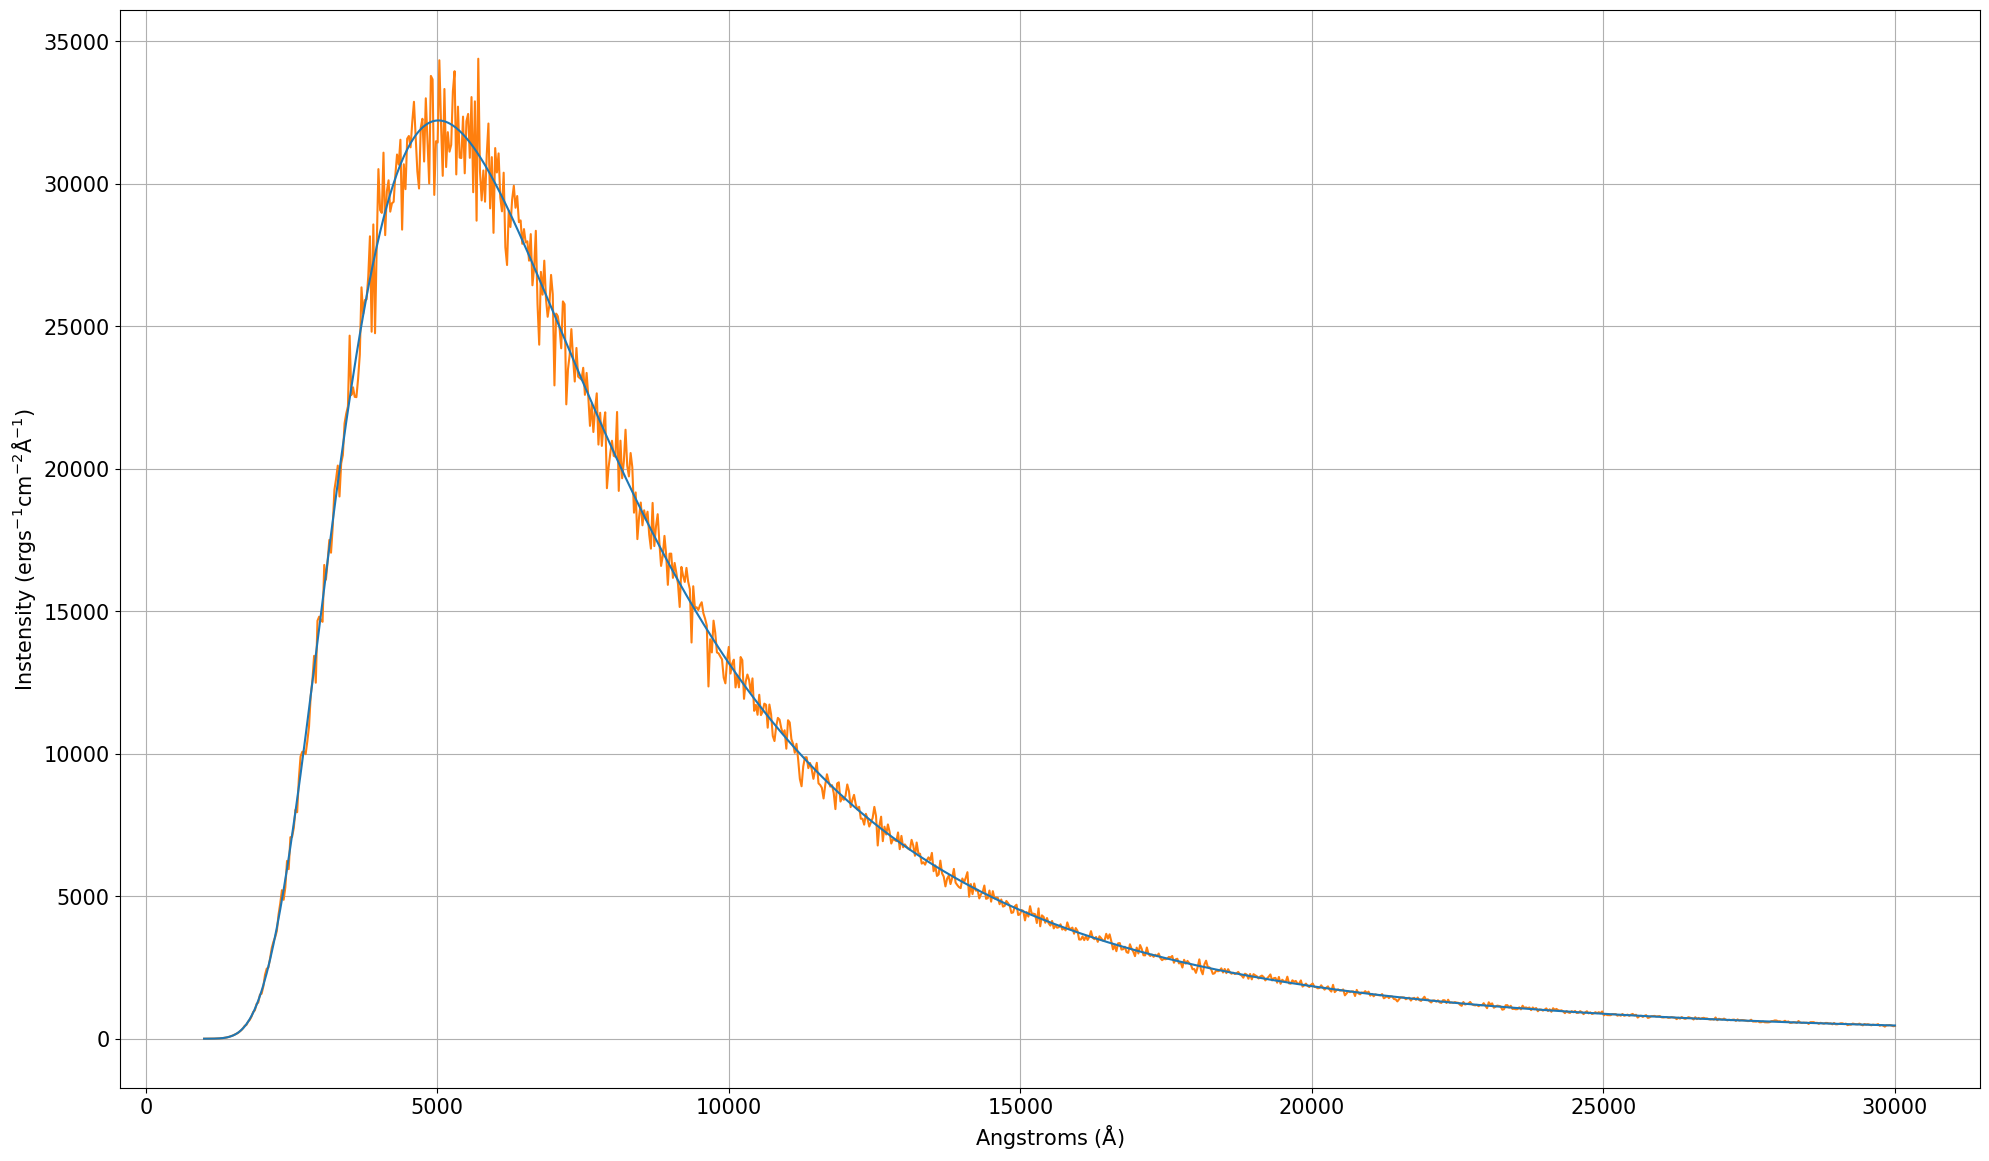

In [20]:
# Blackbody parameters
N = 1000
wavelengths = np.linspace(1000,30000,N)
temp = 5773
z = 3 
snr = 25 # signal to noise ratio

# Create the blackbody curve and plot
true_blackbody = blackbody(wavelengths,temp,z)
error_blackbody = true_blackbody * np.random.randn(N)/snr
obs_blackbody = true_blackbody + error_blackbody

plt.figure(figsize=[24,14])
plt.plot(wavelengths,obs_blackbody,c='tab:orange')
plt.plot(wavelengths,true_blackbody)
plt.xlabel(r'Angstroms ($\rm \AA$)')
plt.ylabel(r'Instensity ($\rm erg s^{-1} cm^{-2} \AA^{-1} $)')
plt.grid()
plt.show()

### Q1. What would the log likelihood function look like?

In [18]:
def lnl_blkbdy(theta,x,y,yerr):


SyntaxError: unexpected EOF while parsing (1382125066.py, line 1)

### Q2. What would be good initial guesses for the star's $T_0$ and $z$ according to MLE?

Unlike the example above add on a random number to both of the true values. For the temperature use a number between 0 and 100 and for the redshift a number between 0 and 1.

### Q3. What would a log prior look like?

In [178]:
def lnprior_blkbdy(theta):


### Q4. What do the final distributions for the values of the temperature and redshift (make a corner plot)? What values do you get for the temperature and redsift?

Code up the log probability function:

In [179]:
def lnprobability_blackbody(theta, x, y, yerr):


Run an MCMC: (maybe consider scaling by different factors when initializing the position of the walkers)

In [ ]:
# intial positions of walkers for all three parameters
pos = np.array([soln.x[0]+np.random.randn(75), soln.x[1]+1e-3*np.random.randn(75)]).T



Plot the position chains:

Find the auto correlation time and create the flat distributions 

Plot the corner plot

Print the fitted values and plot the observed blackbody with the fitted blackbody and make a second plot of the residuals. When getting the fitted blackbody curve you can use np.mean(flat_samples[:, 0]) for the temperature and np.mean(flat_samples[:, 1]) for the redshift.